In [1]:
import json
import os
import datetime
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

In [2]:
CONFIG = {
    'ALPHA': 0.1,
    'GAMMA': 0.99,
    'EPSILON': 0.4,
    'EPSILON_MIN': 0.01,
    'EPSILON_DECAY': 0.995,
    'EPISODES': 10000,
    'PENALTY': -300,
    'TARGET_STEPS': 150,
}

In [3]:
# init
env = gym.make('MountainCar-v0')
n_actions = env.action_space.n

# bins
CART_POSITION_BINS = np.linspace(-1.2, 0.6, 24)
CART_VELOCITY_BINS = np.linspace(-0.07, 0.07, 24)

In [4]:
def load_q_table():
    global q_table
    if os.path.exists("q_table.json"):
        with open("q_table.json", "r") as f:
            q_table = np.array(json.load(f))
    else:
        q_table = np.zeros((25, 25, n_actions))

def save_q_table():
    with open("q_table.json", "w") as f:
        json.dump(q_table.tolist(), f, indent=1)

In [5]:


def discretize_state(state):
    cart_position, cart_velocity = state
    cart_position_idx = np.digitize(cart_position, CART_POSITION_BINS)
    cart_velocity_idx = np.digitize(cart_velocity, CART_VELOCITY_BINS)
    return cart_position_idx, cart_velocity_idx

def choose_action(state, epsilon):
    if np.random.uniform(0,1) < epsilon:
        return env.action_space.sample()
    return np.argmax(q_table[state])

def update_q_value(state, action, reward, next_state):
    best_next_action = np.argmax(q_table[next_state])
    q_target = reward + CONFIG["GAMMA"] * q_table[next_state][best_next_action]
    q_table[state][action] = (1 - CONFIG["ALPHA"]) * q_table[state][action] + CONFIG[
        "ALPHA"
    ] * q_target


def train():
    previousCnt = []
    metrics = {"ep": [], "avg": [], "min": [], "max": []}
    epsilon = CONFIG["EPSILON"]

    for episode in range(CONFIG["EPISODES"]):
        continuous_state, _ = env.reset(seed=42)
        state = discretize_state(continuous_state)
        done = False
        cnt = 0
        while not done:
            action = choose_action(state, epsilon)
            cnt += 1
            next_continuous_state, reward, done, _, _ = env.step(action)
            next_state = discretize_state(next_continuous_state)
            if done and cnt > CONFIG["TARGET_STEPS"]:
                reward = CONFIG["PENALTY"]
            if cnt == 1000:
                done = True
            update_q_value(state, action, reward, next_state)
            state = next_state
        previousCnt.append(cnt)
        epsilon *= CONFIG["EPSILON_DECAY"]
        epsilon = max(CONFIG["EPSILON_MIN"], epsilon)
        if episode % 100 == 0:
            log_metrics(episode, previousCnt, metrics)
    env.close()
    return metrics


def log_metrics(episode, previousCnt, metrics):
    latestRuns = previousCnt[-100:]
    averageCnt = sum(latestRuns) / len(latestRuns)
    metrics["ep"].append(episode)
    metrics["avg"].append(averageCnt)
    metrics["min"].append(min(latestRuns))
    metrics["max"].append(max(latestRuns))
    print(
        f"Run: {episode}, Average: {averageCnt}, Min: {min(latestRuns)}, Max: {max(latestRuns)}"
    )


def plot_metrics(metrics):
    plt.plot(metrics["ep"], metrics["avg"], label="average rewards")
    plt.plot(metrics["ep"], metrics["min"], label="min rewards")
    plt.plot(metrics["ep"], metrics["max"], label="max rewards")
    plt.legend(loc=4)
    t = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    plt.savefig(f"pole-cart-{t}.png")

In [6]:
load_q_table()

In [7]:
metrics = train()

Run: 0, Average: 398.0, Min: 398, Max: 398
Run: 100, Average: 267.11, Min: 160, Max: 663
Run: 200, Average: 279.13, Min: 208, Max: 1000
Run: 300, Average: 615.51, Min: 150, Max: 1000
Run: 400, Average: 201.09, Min: 146, Max: 1000
Run: 500, Average: 694.35, Min: 146, Max: 1000
Run: 600, Average: 919.36, Min: 253, Max: 1000
Run: 700, Average: 1000.0, Min: 1000, Max: 1000
Run: 800, Average: 1000.0, Min: 1000, Max: 1000
Run: 900, Average: 1000.0, Min: 1000, Max: 1000
Run: 1000, Average: 1000.0, Min: 1000, Max: 1000
Run: 1100, Average: 1000.0, Min: 1000, Max: 1000
Run: 1200, Average: 756.47, Min: 240, Max: 1000
Run: 1300, Average: 959.6, Min: 303, Max: 1000
Run: 1400, Average: 1000.0, Min: 1000, Max: 1000
Run: 1500, Average: 1000.0, Min: 1000, Max: 1000
Run: 1600, Average: 1000.0, Min: 1000, Max: 1000
Run: 1700, Average: 1000.0, Min: 1000, Max: 1000
Run: 1800, Average: 1000.0, Min: 1000, Max: 1000
Run: 1900, Average: 1000.0, Min: 1000, Max: 1000
Run: 2000, Average: 1000.0, Min: 1000, Max: 1

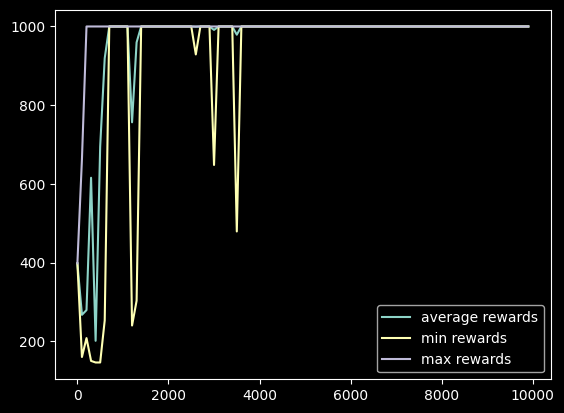

In [8]:
plot_metrics(metrics)

In [9]:
save_q_table()

In [10]:

env = gym.make('MountainCar-v0', render_mode="human")
continuous_state, _ = env.reset(seed=42)
state = discretize_state(continuous_state)
done = False
while not done:
    action = np.argmax(q_table[state])
    next_continuous_state, reward, done, _, _ = env.step(action)
    state = discretize_state(next_continuous_state)
env.close()

KeyboardInterrupt: 